In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
batch_size=128

In [3]:
transformer = torchvision.transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

In [27]:
train_dataset = torchvision.datasets.CIFAR10(
    root='data/',
    train=True,
    transform=transformer,
    download=True,
)

test_dataset = torchvision.datasets.CIFAR10(
    root='data/',
    train=False,
    transform=transforms.ToTensor(),
    download=True,
)

Files already downloaded and verified
Files already downloaded and verified


In [28]:
class CNN(nn.Module):
    def __init__(self, output_classes=10):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )
        # self.conv4 = nn.Sequential(
        #     nn.Conv2d(128, 256, 3, padding=1),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(),
        #     nn.Conv2d(256, 256, 3, padding=1),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(),
        #     nn.Conv2d(256, 256, 3, padding=1),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(),
        #     nn.MaxPool2d(2),
        # )
        # self.conv5 = nn.Sequential(
        #     nn.Conv2d(256, 512, 3, padding=1),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(),
        #     nn.Conv2d(512, 512, 3, padding=1),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(),
        #     nn.Conv2d(512, 512, 3, padding=1),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(),
        #     nn.MaxPool2d(2),
        # )
        self.fc1 = nn.Linear(128* 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, output_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        outputs = outputs.view(outputs.size(0), -1)
        outputs = F.dropout(outputs, p=0.2)
        outputs = self.fc1(outputs)
        outputs = F.relu(outputs)
        outputs = F.dropout(outputs, p=0.4)
        outputs = self.fc2(outputs)
        return outputs  

In [29]:
model = CNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device used: {device}')

model.to(device=device)

Device used: cuda


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [31]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,    
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,    
)

In [36]:
def train(model, optimizer, criterion, train_loader, test_loader, n_epochs=80):
    train_losses = []
    test_losses = []
    
    for it in range(1, n_epochs+1):
        
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
        train_losses.append(np.mean(train_loss))
        
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss.append(loss.item())
        
        test_losses.append(np.mean(test_loss))
            
        print(f'Iteration {it}/{n_epochs}')
        
    return (train_losses, test_losses)

In [37]:
train_losses, test_losses = train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
)

Iteration 1/80
Iteration 2/80
Iteration 3/80
Iteration 4/80
Iteration 5/80
Iteration 6/80
Iteration 7/80
Iteration 8/80
Iteration 9/80
Iteration 10/80
Iteration 11/80
Iteration 12/80
Iteration 13/80
Iteration 14/80
Iteration 15/80
Iteration 16/80
Iteration 17/80
Iteration 18/80
Iteration 19/80
Iteration 20/80
Iteration 21/80
Iteration 22/80
Iteration 23/80
Iteration 24/80
Iteration 25/80
Iteration 26/80
Iteration 27/80
Iteration 28/80
Iteration 29/80
Iteration 30/80
Iteration 31/80
Iteration 32/80
Iteration 33/80
Iteration 34/80
Iteration 35/80
Iteration 36/80
Iteration 37/80
Iteration 38/80
Iteration 39/80
Iteration 40/80
Iteration 41/80
Iteration 42/80
Iteration 43/80
Iteration 44/80
Iteration 45/80
Iteration 46/80
Iteration 47/80
Iteration 48/80
Iteration 49/80
Iteration 50/80
Iteration 51/80
Iteration 52/80
Iteration 53/80
Iteration 54/80
Iteration 55/80
Iteration 56/80
Iteration 57/80
Iteration 58/80
Iteration 59/80
Iteration 60/80
Iteration 61/80
Iteration 62/80
Iteration 63/80
I

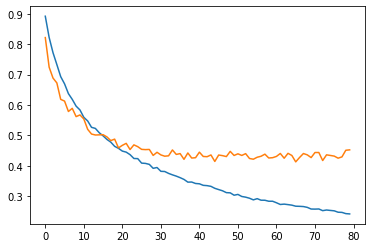

In [38]:
plt.plot(train_losses)
plt.plot(test_losses)

In [39]:
torch.save(model.state_dict(), 'cifar10_cnn.pt')

In [42]:
def validate(model, dataset, device='cpu', batch_size=128):
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
    )
    
    total_correct = 0
    total_tested = 0
    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, dim=1)
        
        total_correct += torch.sum(predicted == targets)
        total_tested += inputs.shape[0]
        
        
    accuracy = total_correct/total_tested
    return accuracy

In [46]:
accuracy = validate(
    model,
    test_dataset,
    device=device,
    batch_size=batch_size,
)
print(f'Model accuracy: {accuracy:.2f}')

Model accuracy: 0.86


In [53]:
def get_predicted_labels(model, dataset, batch_size=128):
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
    )
    
    predictions = np.array([])
    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        
        predictions = np.concatenate((predictions, predicted.cpu().numpy()))
        
    return predictions

In [55]:
import itertools


def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues
):
    """
    This functions prints and plots Confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix without normalization")

    print(cm)

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix without normalization
[[885   5  25  18  13   1   5   7  33   8]
 [  5 947   3   4   1   0   4   0   5  31]
 [ 26   1 818  47  36  31  22  14   2   3]
 [  8   1  45 751  42 106  19  19   5   4]
 [  7   1  30  39 848  26  26  22   1   0]
 [  7   1  27 115  25 798   8  17   1   1]
 [  7   1  32  36  14  14 888   5   2   1]
 [  6   0  17  20  26  25   1 903   1   1]
 [ 43  12   9   3   4   0   4   0 913  12]
 [ 25  36   5   5   0   3   2   3  12 909]]


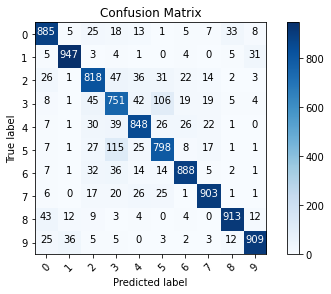

In [56]:
from sklearn.metrics import confusion_matrix

test_predictions = get_predicted_labels(
    model=model,
    dataset=test_dataset,
    batch_size=batch_size,
)

test_targets = test_dataset.targets

cm = confusion_matrix(test_targets, test_predictions)
plot_confusion_matrix(cm, list(range(10)))
